In [1]:
from pathlib import Path # 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import geopandas as gpd
import pandas as pd
import tfv.xarray
import xarray as xr  
from tfv.extractor import FvExtractor
from tfv.timeseries import FvTimeSeries
from shapely import wkt
# A nice plot default
sns.set(style='white', font_scale=0.8)

In [2]:
# Use the correct DBFS path for the shared volume
model_folder = Path('/Projects2/csiem/model/csiem_model_tfvaed_1.6/outputs/results/')
model_file = 'csiem_B009_20221101_20240401_WQ_WQ.nc'
ds = xr.open_dataset(model_folder/model_file, decode_times=True, engine='netcdf4')
fv = ds.tfv
fv

<xarray.Dataset> Size: 3TB
Dimensions:                        (Time: 3091, NumLayerFaces3D: 534016,
                                    NumCells2D: 30206, NumCells3D: 503810)
Coordinates:
  * Time                           (Time) datetime64[ns] 25kB 2022-11-02 ... ...
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables: (12/444)
    ResTime                        (Time) datetime64[ns] 25kB 2022-11-02 ... ...
    layerface_Z                    (Time, NumLayerFaces3D) float32 7GB ...
    stat                           (Time, NumCells2D) int32 373MB ...
    H                              (Time, NumCells2D) float32 373MB ...
    D                              (Time, NumCells2D) float32 373MB ...
    V_x                            (Time, NumCells3D) float32 6GB ...
    ...                             ...
    WQ_DIAG_OAS_A_IOP3_BAND16      (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_A_IOP4_BAND16      (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_A_BAND16           (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_B_BAND16           (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_KD                 (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_SECCHI             (Time, NumCells3D) float32 6GB ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

In [3]:
import geopandas as gpd
import pandas as pd

# Load the shapefile
shp_path = r"../../gis/Curtain/New_Curtain_line_LL_100m.shp"
gdf = gpd.read_file(shp_path)
# Make sure the CRS is geographic (lat/lon)
if gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)

# Extract coordinates
gdf["longitude"] = gdf.geometry.x
gdf["latitude"]  = gdf.geometry.y

# Drop the geometry column if you want just lat/lon + attributes
df = gdf.drop(columns="geometry")
polyline = df[['longitude', 'latitude']].to_numpy()


Creating animation with 360 frames...
Saving animation to outputs/curtain_1panel_animation_2023-01-AGE_long.gif...
✅ Animation saved successfully to outputs/curtain_1panel_animation_2023-01-AGE_long.gif


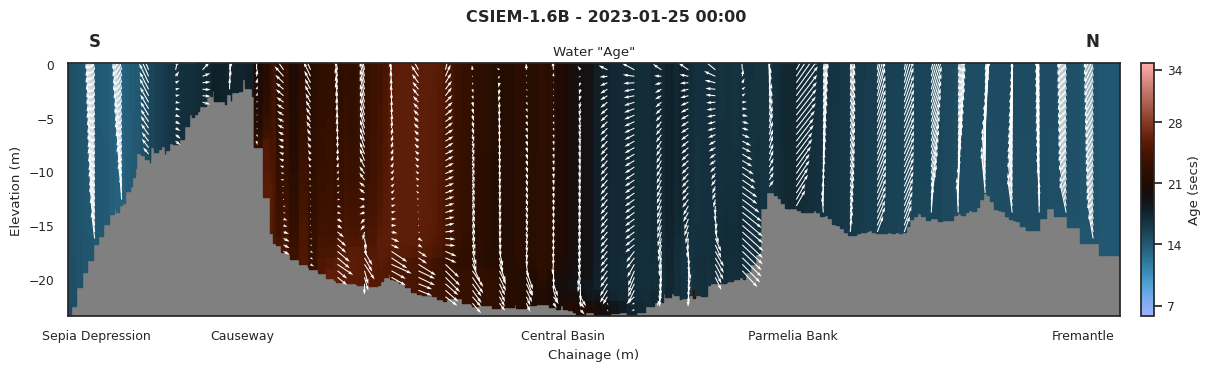

In [ ]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

# --- Output setup ---
output_folder = Path('./outputs')
output_folder.mkdir(exist_ok=True)
out_file_gif = output_folder / 'curtain_1panel_animation_2023-01-AGE_long.gif'

# --- Time range for animation ---
time_start = '2023-01-25 00:00'
time_end = '2023-03-25 23:00'
fvx = fv.sel(Time=slice(time_start, time_end))

# --- Plot style settings ---
sns.set_theme(style='white', font_scale=0.8)

# --- Figure: single curtain axis ---
fig = plt.figure(figsize=(12, 3.6), constrained_layout=True)
ax_sal_curtain = fig.add_subplot(1, 1, 1)
ax_sal_curtain.set_facecolor('grey')

# --- Initial frame (frame 0) ---
sal_curtain = fvx.plot_curtain(
    polyline, "WQ_TRC_AGE", 0, ax=ax_sal_curtain,
    ec="face", cmap="berlin", clim=(5e5, 3e6), colorbar=False   # berlin  # RdBu
)
cbar_sal = fig.colorbar(
    sal_curtain.patch, ax=ax_sal_curtain,
    orientation="vertical", fraction=0.025, pad=0.02
)
cbar_sal.set_ticks([604800, 1209600, 1814400, 2419200, 2937600])
cbar_sal.set_ticklabels(['7', '14','21', '28', '34'])
cbar_sal.set_label("Age (days)")

sal_vec = fvx.plot_curtain_vector(
    polyline, 0, ax=ax_sal_curtain,
    tangential=False, scale=5, color="w", width=0.001
)

# --- Format curtain axis ---
ax_sal_curtain.set_title('Water "Age"')

# Custom x-ticks (from your MATLAB definition)
xticks = [1000, 6000, 17060, 25000, 35000]
xticklabels = ['Sepia Depression', 'Causeway', 'Central Basin', 'Parmelia Bank', 'Fremantle']
ax_sal_curtain.set_xticks(xticks)
ax_sal_curtain.set_xticklabels(xticklabels, rotation=0, fontsize=9)
ax_sal_curtain.set_xlabel("Transect Location")

# Add N/S labels
ax_sal_curtain.text(0.02, 1.05, 'S', transform=ax_sal_curtain.transAxes,
                    fontsize=12, fontweight='bold', va='bottom')
ax_sal_curtain.text(0.98, 1.05, 'N', transform=ax_sal_curtain.transAxes,
                    fontsize=12, fontweight='bold', va='bottom', ha='right')

# Optional x-axis label (if distance units are relevant)
#ax_sal_curtain.set_xlabel("Distance along section (m)")

# --- Animation function ---
def animate(i):
    sal_curtain.set_time_current(i)
    sal_vec.set_time_current(i)

    date = sal_curtain.get_time_current()
    fig.suptitle(f'CSIEM-1.6B - {date.strftime("%Y-%m-%d %H:%M")}',
                 fontweight='bold')

# --- Create & save animation ---
nframes = fvx.sizes['Time']
print(f"Creating animation with {nframes} frames...")

anim = animation.FuncAnimation(fig, animate, frames=nframes,
                               repeat=False, interval=200)

print(f"Saving animation to {out_file_gif}...")
writer = animation.PillowWriter(fps=3)
anim.save(out_file_gif, writer=writer, dpi=100)
print(f"✅ Animation saved successfully to {out_file_gif}")